### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import netCDF4 as nc
import datetime 
import seaborn

### Завантажження данних у словник

In [2]:

data = {
    year: {
            "climate": nc.Dataset("data/main/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/main/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [3]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

Одразу позбуваємось даних про вітер на висоті 50 метрів

In [4]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

DATA = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        DATA[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data).drop(["WS50M", "WD50M"], axis=1)


In [7]:
DATA["52.25x36.75"].head()

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M,co_conc,no2_conc,no_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc,time
0,0.24,150.309998,3.00,99.019997,6.13,-2.67,165.812546,2.094728,0.114966,45.673897,15.915214,14.042672,2.042157,2021-01-01
1,0.28,233.199997,2.90,99.410004,4.68,-3.19,190.595673,4.180746,0.262915,26.774969,5.392114,4.794663,0.673026,2021-01-02
2,0.35,199.509995,2.22,100.440002,3.83,-6.33,196.013351,1.417576,0.094587,53.645283,11.483358,10.168221,0.763421,2021-01-03
3,0.33,159.449997,2.39,100.309998,4.63,-5.51,192.674072,2.827499,0.091319,54.002937,14.512181,12.881714,3.194430,2021-01-04
4,0.25,131.740005,2.33,99.980003,4.35,-5.62,144.451233,1.084685,0.033161,65.768387,8.892210,7.685567,0.367649,2021-01-05


### Статистичні данні стосовно всіх видів викидів

In [8]:
stats = {
    atribute: np.array([])
    for atribute in atributes_polution
}
for val in DATA.values():
    for atribute in atributes_polution:
        stats[atribute] = np.append(stats[atribute], val[atribute])

### Візуалізація "сирих" данних

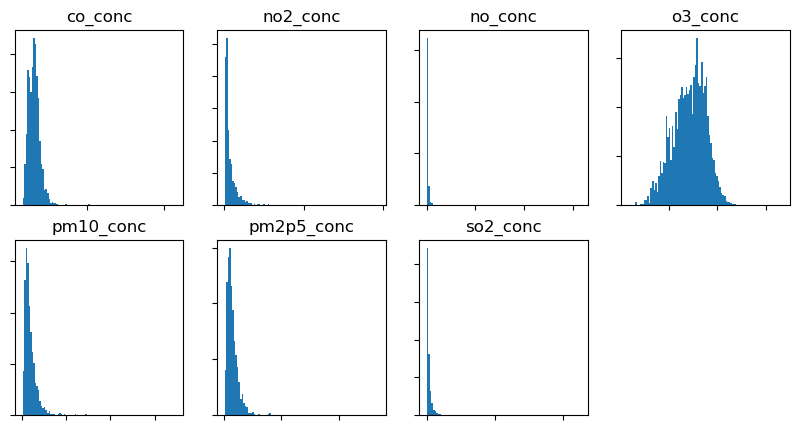

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in stats.keys():
    stat = stats[label]
    ax = axes[i]
    i+=1
    ax.hist(np.array(stat), bins=100)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

Застосуємо інтервали

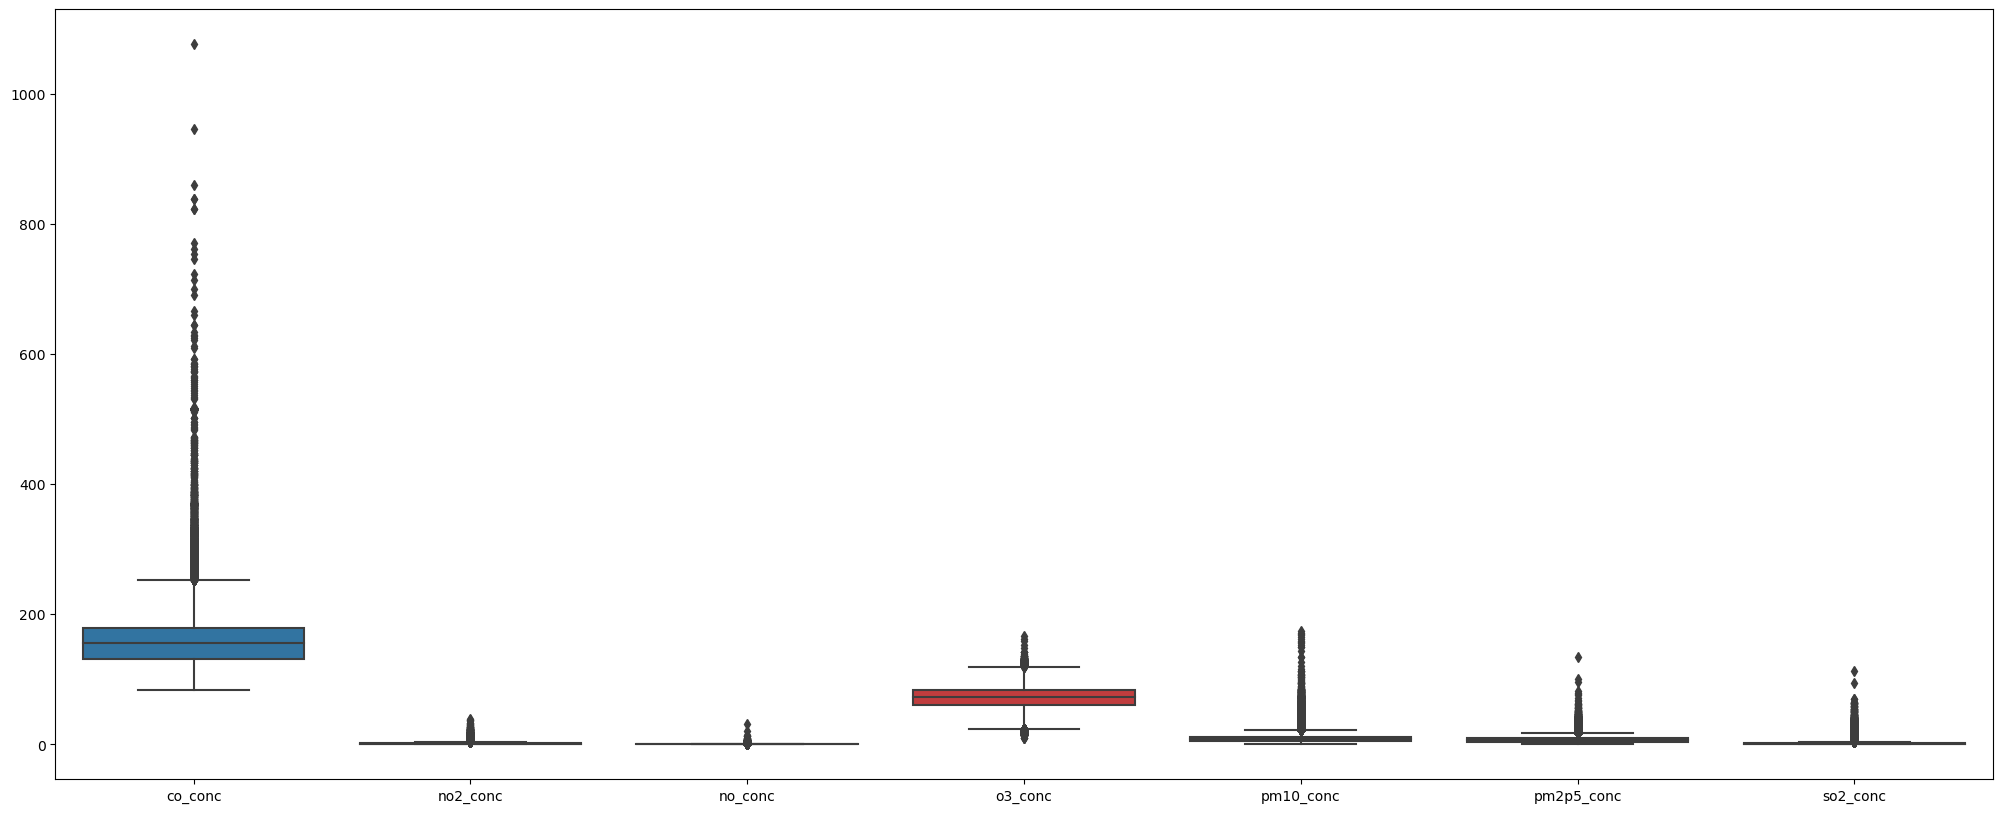

In [13]:
plt.figure(figsize=(25,10))
seaborn.boxplot(data=pd.DataFrame(stats))
plt.show()

In [9]:
ranges = [[0, 450], [0, 12], [0, 8], [0, 130], [0, 50], [0, 25], [0, 7]]

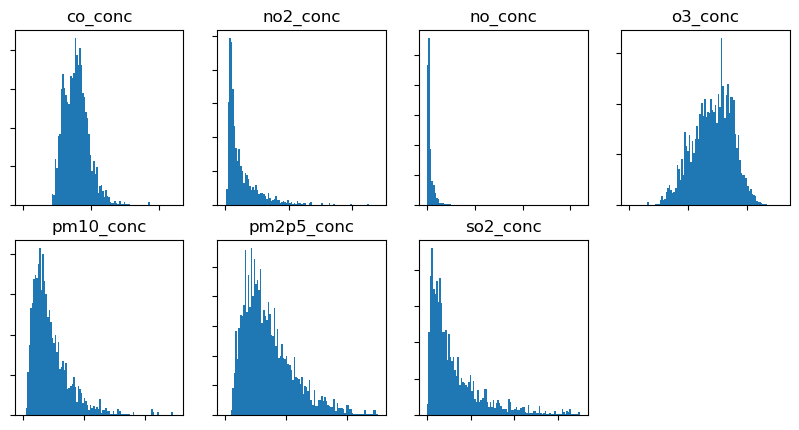

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in stats.keys():
    stat = stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100, range= _range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

In [17]:
np.sum(stats["no_conc"] > 1) / np.sum(stats["no_conc"] > 0) * 100

1.5135643298415258

In [16]:
np.sum(stats["so2_conc"] > 10) / np.sum(stats["so2_conc"] > 0) * 100

1.2291163040558688

In [18]:
a = [i for i in DATA["52.25x36.75"].columns]
for i in ["time", 'co_conc','no2_conc','no_conc','o3_conc','pm10_conc','pm2p5_conc','so2_conc']:
    a.remove(i)
a

['ALLSKY_SFC_SW_DWN', 'WD10M', 'QV2M', 'PS', 'WS10M', 'T2M']

In [19]:
DATA["52.25x36.75"].get(a).corr()

,ALLSKY_SFC_SW_DWN,WD10M,QV2M,PS,WS10M,T2M
ALLSKY_SFC_SW_DWN,1.000000,-0.185005,0.648201,0.120202,-0.338364,0.641930
WD10M,-0.185005,1.000000,-0.205908,-0.179114,0.033519,-0.196132
QV2M,0.648201,-0.205908,1.000000,0.166831,-0.130927,0.922823
PS,0.120202,-0.179114,0.166831,1.000000,0.217696,0.280368
WS10M,-0.338364,0.033519,-0.130927,0.217696,1.000000,-0.106707
T2M,0.641930,-0.196132,0.922823,0.280368,-0.106707,1.000000
